# Nichesphere differential co-localization tutorial

Nichesphere is an sc-verse compatible Python library which allows the user to find differentially co-localized cellular niches and biological processes involved in their interactions based on cell type pairs co-localization probabilities in different conditions. Cell type pair co-localization probabilities are obtained in different ways: from deconvoluted Visium 10x / PIC-seq data (probabilities of finding each cell type in each spot / multiplet), or counting cell boundaries overlaps for each cell type pair in single cell spatial data (MERFISH , CODEX ...). This tutorial focuses on defining groups of cells that converge or split in disease (Ischemia) based on differential co-localization. 

Nichesphere also offers the possibility to look at localized differential cell - cell communication based on Ligand-Receptor pairs expression data, such as results from CrossTalkeR [ref]. This is addressed in the localized differential communication tutorial.


## Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
import leidenalg
import sklearn
import igraph as ig
warnings.filterwarnings("ignore")

## My package test
#import sys
#sys.path.append("/data/hu367653/source/Nichesphere-main/nichesphere/nichesphere")
#import tl_new
import nichesphere

In [2]:
import mudata as md

## Data at first glance

In this example we will use data from the Myocardial Infarction atlas from Kuppe, C. et. Al., 2022

In [3]:
mudata=md.read('/data/Graph4Patients/data/final_objects/heart_MI_ST_SC_23samples.h5mu')

This is a subset with 23 samples (samples with less than 1500 cells in the snRNA-seq data were filtered out), and 33 different cell subtypes

Deconvoluted data (Cell type probabilities per spot): In a previous step, we used MOSCOT to deconvolute cell subtypes in visium slices from the same 23 samples , getting matrices of probabilities of each cell of being in each spot.

Then we got cell type probabilities per spot summing the probabilities of cells of the same kind in each spot; thus getting concatenated cell type probability matrices for all samples.

(you can have a closer look at these steps in the preprocessing tutorial)

In [4]:
CTprops=pd.read_csv('./CTprops.csv', index_col=0)
CTprops

Fib1_SCARA5  \
AAACAAGTATCTCCCA-1-1-0-0-0                          0.000000e+00   
AAACAATCTACTAGCA-1-1-0-0-0                          0.000000e+00   
AAACACCAATAACTGC-1-1-0-0-0                          0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                          1.373226e-25   
AAACAGCTTTCAGAAG-1-1-0-0-0                          0.000000e+00   
...                                                          ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCCATACAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   

                                                      damaged_CM  \
AAACAAGTATCTCCCA-1-1-0-0-0                          0.000000e+00   
AAACAATCTACTAGCA-1-1-0-0-0                          2.691729e-21   
AAACACCAATAACTGC-1-1-0-0-0                          0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                          0.000000e+00   
AAACAGCTTTCAGAAG-1-1-0-0-0                          0.000000e+00   
...                                                          ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  3.327203e-01   
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCCATACAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  5.445488e-01   

                                                    Capillary_Endo  \
AAACAAGTATCTCCCA-1-1-0-0-0                            0.000000e+00   
AAACAATCTACTAGCA-1-1-0-0-0                            0.000000e+00   
AAACACCAATAACTGC-1-1-0-0-0                            0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                            0.000000e+00   
AAACAGCTTTCAGAAG-1-1-0-0-0                            0.000000e+00   
...                                                            ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    0.000000e+00   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    0.000000e+00   
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    0.000000e+00   
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    1.621940e-18   
TTGTTTCCATACAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    0.000000e+00   

                                                    LYVE_FOLR_Macrophages  \
AAACAAGTATCTCCCA-1-1-0-0-0                                   8.333133e-16   
AAACAATCTACTAGCA-1-1-0-0-0                                   0.000000e+00   
AAACACCAATAACTGC-1-1-0-0-0                                   0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                                   0.000000e+00   
AAACAGCTTTCAGAAG-1-1-0-0-0                                   0.000000e+00   
...                                                                   ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   
TTGTTTCCATACAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   

                                                     Fib3_C7    healthy_CM  \
AAACAAGTATCTCCCA-1-1-0-0-0                          0.000000  0.000000e+00   
AAACAATCTACTAGCA-1-1-0-0-0                          0.445912  5.540884e-01   
AAACACCAATAACTGC-1-1-0-0-0                          0.000000  0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                          0.499762  3.111796e-13   
AAACAGCTTTCAGAAG-1-1-0-0-0                          0.000000  0.000000e+00   
...                                                      ...           ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000  6.455526e-01   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-

## Co-localization

We computed then co-localization probabilities from the cell type probability matrices. Here we got concatenated co-localization sample matrices of cell type x cell type.

Then we reshaped the co-localization data into a matrix of cell type pairs x samples.

(you can have a closer look at these steps in the preprocessing tutorial)

In [5]:
colocPerSample=pd.read_csv('./colocPerSample.csv', index_col=0)
colocPerSample

Fib1_SCARA5-Fib1_SCARA5  Fib1_SCARA5-damaged_CM  \
control_P17                 0.017603            3.084543e-04   
RZ_P9                       0.009307            4.289964e-04   
IZ_P15                      0.030351            0.000000e+00   
RZ_P6                       0.040470            4.409681e-04   
RZ_BZ_P3                    0.021508            2.924325e-04   
FZ_P14                      0.010915            5.932359e-05   
RZ_BZ_P12                   0.029538            1.290557e-04   
FZ_GT_P4                    0.030297            0.000000e+00   
GT_IZ_P13                   0.018084            0.000000e+00   
GT_IZ_P15                   0.020017            3.980737e-05   
FZ_P20                      0.070308            0.000000e+00   
RZ_FZ_P5                    0.029320            1.307565e-04   
GT_IZ_P9                    0.019715            1.999953e-04   
RZ_P3                       0.057060            1.686446e-03   
FZ_GT_P19                   0.021516            1.100737e-04   
FZ_P18                      0.041702            0.000000e+00   
IZ_P10                      0.030229            9.586357e-05   
control_P7                  0.007382            2.349106e-04   
RZ_P11                      0.010735            8.770894e-31   
control_P1                  0.043871            8.279132e-04   
RZ_BZ_P2                    0.019492            7.422823e-05   
control_P8                  0.022322            8.072949e-04   
RZ_GT_P2                    0.014946            2.958828e-04   

             Fib1_SCARA5-Capillary_Endo  Fib1_SCARA5-LYVE_FOLR_Macrophages  \
control_P17                    0.000992                       2.507278e-04   
RZ_P9                          0.000738                       3.342737e-06   
IZ_P15                         0.000027                       1.859005e-04   
RZ_P6                          0.002752                       3.609917e-04   
RZ_BZ_P3                       0.000567                       5.747034e-05   
FZ_P14                         0.000740                       6.678659e-04   
RZ_BZ_P12                      0.001448                       4.188154e-04   
FZ_GT_P4                       0.000009                       0.000000e+00   
GT_IZ_P13                      0.000154                       3.540328e-04   
GT_IZ_P15                      0.000107                       1.413835e-05   
FZ_P20                         0.000063                       1.740452e-04   
RZ_FZ_P5                       0.002286                       4.717095e-04   
GT_IZ_P9                       0.000250                       3.609267e-33   
RZ_P3                          0.001476                       8.593347e-04   
FZ_GT_P19                      0.000403                       6.173076e-04   
FZ_P18                         0.000663                       1.742412e-04   
IZ_P10                         0.000610                       3.347724e-04   
control_P7                     0.000457                       6.240571e-05   
RZ_P11                         0.001312                       1.102293e-04   
control_P1                     0.001498                       7.997668e-04   
RZ_BZ_P2                       0.000803                       1.589867e-04   
control_P8                     0.002369                       3.393776e-05   
RZ_GT_P2                       0.001215                       2.882729e-04   

             Fib1_SCARA5-Fib3_C7  Fib1_SCARA5-healthy_CM  \
control_P17             0.007062            2.586003e-03   
RZ_P9                   0.005204            1.439230e-03   
IZ_P15                  0.001200            0.000000e+00   
RZ_P6                   0.008687            2.927885e-03   
RZ_BZ_P3                0.002408            4.829458e-04   
FZ_P14                  0.003387            2.537452e-04   
RZ_BZ_P12               0.004993            9.484252e-04   
FZ_GT_P4                0.000385            0.000000e+00   
GT_IZ_P13               0.003069            0.000000e+00   
GT_

The sum of the probabilities of every cell type pair in a sample must be = 1

In [6]:
colocPerSample.sum(axis=1)

control_P17    1.0
RZ_P9          1.0
IZ_P15         1.0
RZ_P6          1.0
RZ_BZ_P3       1.0
FZ_P14         1.0
RZ_BZ_P12      1.0
FZ_GT_P4       1.0
GT_IZ_P13      1.0
GT_IZ_P15      1.0
FZ_P20         1.0
RZ_FZ_P5       1.0
GT_IZ_P9       1.0
RZ_P3          1.0
FZ_GT_P19      1.0
FZ_P18         1.0
IZ_P10         1.0
control_P7     1.0
RZ_P11         1.0
control_P1     1.0
RZ_BZ_P2       1.0
control_P8     1.0
RZ_GT_P2       1.0
dtype: float64

Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the co-localization table we'll generate in the next step.

In [7]:
cell_types=CTprops.columns
oneCTints=cell_types+'-'+cell_types

Conditions

To subset the samples, we will use a dataframe of sample names and conditions.

In [8]:
sampleTypesDF=pd.read_csv('../../../../nichesphere_tutorial_data/MI_sampleTypesDF.csv')
sampleTypesDF

Unnamed: 0       sample sampleType
0            0  control_P17   myogenic
1            1        RZ_P9     remote
2            2       IZ_P15   ischemic
3            3        RZ_P6     remote
4            4     RZ_BZ_P3     border
5            5       FZ_P14   fibrotic
6            6    RZ_BZ_P12     border
7            7     FZ_GT_P4   fibrotic
8            8    GT_IZ_P13   ischemic
9            9    GT_IZ_P15   ischemic
10          10       FZ_P20   fibrotic
11          11     RZ_FZ_P5   fibrotic
12          12     GT_IZ_P9   ischemic
13          13        RZ_P3     remote
14          14    FZ_GT_P19   fibrotic
15          15       FZ_P18   fibrotic
16          16       IZ_P10   ischemic
17          17   control_P7   myogenic
18          18       RZ_P11     remote
19          19   control_P1   myogenic
20          20     RZ_BZ_P2     border
21          21   control_P8   myogenic
22          22     RZ_GT_P2     remote

Differential co-localization analysis

We will test differential co-localization between two different conditions using Wilcoxon (rank sums) tests. Here we will focus on the differences between myogenic and ischemic samples.

In [9]:
myo_iscDF=nichesphere.coloc.diffColoc_test(coloc_pair_sample=colocPerSample, sampleTypes=sampleTypesDF, exp_condition='ischemic', ctrl_condition='myogenic')
myo_iscDF

pairs  \
pairs                                                                  
Fib1_SCARA5-Fib1_SCARA5                      Fib1_SCARA5-Fib1_SCARA5   
Fib1_SCARA5-damaged_CM                        Fib1_SCARA5-damaged_CM   
Fib1_SCARA5-Capillary_Endo                Fib1_SCARA5-Capillary_Endo   
Fib1_SCARA5-LYVE_FOLR_Macrophages  Fib1_SCARA5-LYVE_FOLR_Macrophages   
Fib1_SCARA5-Fib3_C7                              Fib1_SCARA5-Fib3_C7   
...                                                              ...   
NK_T-NK                                                      NK_T-NK   
NK_T-CD_8                                                  NK_T-CD_8   
NK_T-Purkinje_fibers                            NK_T-Purkinje_fibers   
NK_T-Adipo                                                NK_T-Adipo   
NK_T-NK_T                                                  NK_T-NK_T   

                                  statistic   p-value  
pairs                                                  
Fib1_SCARA5-Fib1_SCARA5            0.489898  0.624206  
Fib1_SCARA5-damaged_CM             -2.44949  0.014306  
Fib1_SCARA5-Capillary_Endo        -2.204541  0.027486  
Fib1_SCARA5-LYVE_FOLR_Macrophages -0.489898  0.624206  
Fib1_SCARA5-Fib3_C7                -2.44949  0.014306  
...                                     ...       ...  
NK_T-NK                           -0.979796  0.327187  
NK_T-CD_8                         -0.857321  0.391267  
NK_T-Purkinje_fibers                    0.0       1.0  
NK_T-Adipo                        -0.612372  0.540291  
NK_T-NK_T                          0.734847  0.462433  

[1089 rows x 3 columns]

We'll visualize the Wilcoxon test scores in a heatmap

In [10]:
#### test HM
## Not filtering
myo_isc_HM=nichesphere.tl.pval_filtered_HMdf(testDF=myo_iscDF, oneCTinteractions=oneCTints, p=1, cell_types=cell_types)

As the cells classified as proliferating cells (prolif) are many different cell types and thus hard to interpret, we'll remove them for further analysis.

In [11]:
## No prolif cells
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.columns.str.contains('prolif')==False,myo_isc_HM.index.str.contains('prolif')==False]

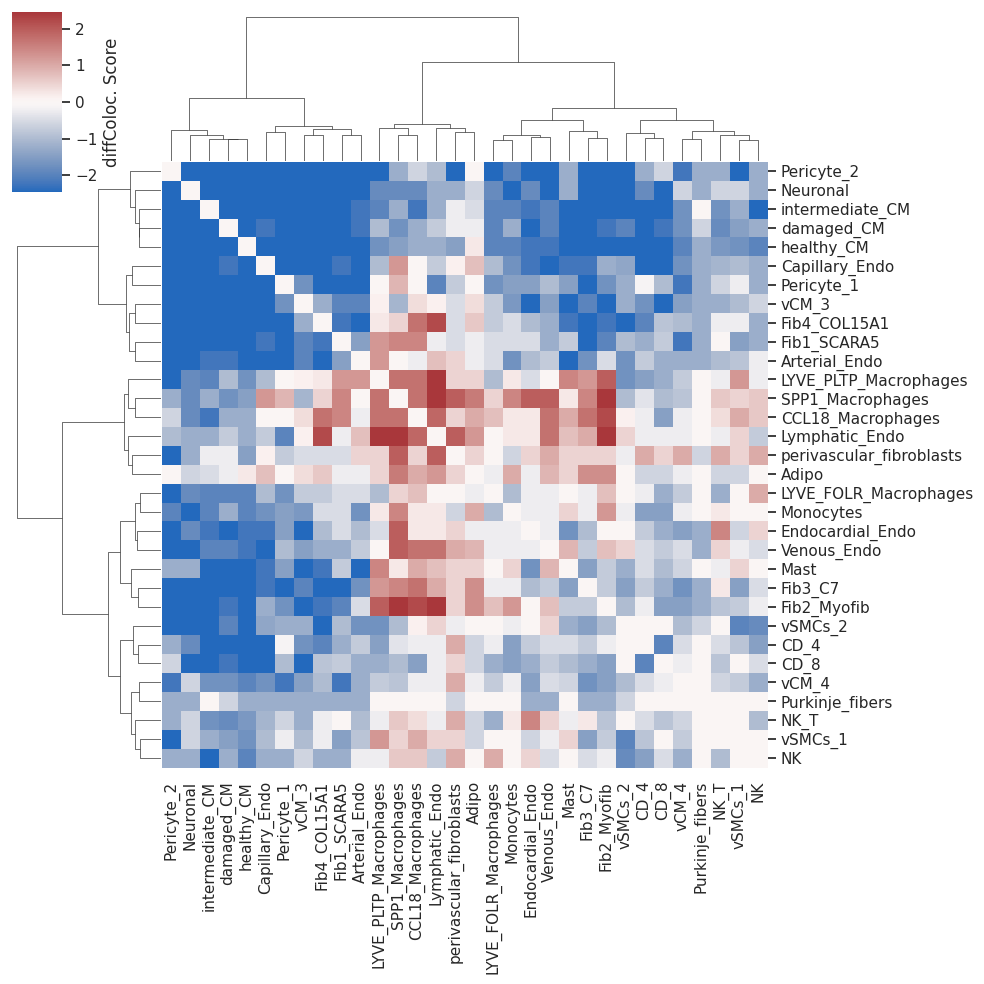

In [12]:
## Plot heatmap
sns.set(font_scale=1)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'})

To get groups of interacting cells , we will cut the hierarchical clustering dendrogram from the clustermap above, obtaining 4 clusters

In [13]:
#### Clusters from clustermap on scores matrix
heatClusts=scipy.cluster.hierarchy.fcluster(plot.dendrogram_col.linkage, 2, depth=4)
nichesDF=pd.Series(heatClusts, index=plot.dendrogram_col.data.columns)

In [14]:
nichesDF

Fib1_SCARA5                 2
damaged_CM                  1
Capillary_Endo              2
LYVE_FOLR_Macrophages       4
Fib3_C7                     4
healthy_CM                  1
Fib2_Myofib                 4
Endocardial_Endo            4
Arterial_Endo               2
Neuronal                    1
Pericyte_1                  2
LYVE_PLTP_Macrophages       3
intermediate_CM             1
vCM_3                       2
Pericyte_2                  1
Mast                        4
Monocytes                   4
Fib4_COL15A1                2
SPP1_Macrophages            3
Venous_Endo                 4
vCM_4                       5
vSMCs_1                     5
CCL18_Macrophages           3
perivascular_fibroblasts    3
CD_4                        5
vSMCs_2                     5
Lymphatic_Endo              3
NK                          5
CD_8                        5
Purkinje_fibers             5
Adipo                       3
NK_T                        5
dtype: int32

The we will annotate our cell groups and visualise them with different colors in the co-localization network , for which we will need a niche assignment dictionary (change the keys of this dictionary for your preferred names)

In [15]:
niches_dict={'1_CardioNeuro':list(nichesDF.index[nichesDF==1]),
     '2_Fibro_vCM':list(nichesDF.index[nichesDF==2]),
     '3_Macro':list(nichesDF.index[nichesDF==3]),
     '4_MyofibImmune':list(nichesDF.index[nichesDF==4]),
     '5_Immune':list(nichesDF.index[nichesDF==5]),
     }

We will assign each group a color too

In [16]:
#Niches colors
clist=["#BC3C29", "#0072B5", "#ffff33", "#4daf4a", "#EE4C97"]
niche_cols=pd.Series(clist, index=['1_CardioNeuro', '2_Fibro_vCM', '3_Macro', '4_MyofibImmune', '5_Immune'])

And we will assign each cell its group and group based color as well

In [17]:
niches_df=nichesphere.tl.cells_niche_colors(CTs=CTprops.columns, niche_colors=niche_cols, niche_dict=niches_dict)
niches_df.to_csv('./niches_df_MIvisium.csv')
niches_df

cell           niche    color
cell                                                                       
Fib1_SCARA5                            Fib1_SCARA5     2_Fibro_vCM  #0072B5
damaged_CM                              damaged_CM   1_CardioNeuro  #BC3C29
Capillary_Endo                      Capillary_Endo     2_Fibro_vCM  #0072B5
LYVE_FOLR_Macrophages        LYVE_FOLR_Macrophages  4_MyofibImmune  #4daf4a
Fib3_C7                                    Fib3_C7  4_MyofibImmune  #4daf4a
healthy_CM                              healthy_CM   1_CardioNeuro  #BC3C29
Fib2_Myofib                            Fib2_Myofib  4_MyofibImmune  #4daf4a
Endocardial_Endo                  Endocardial_Endo  4_MyofibImmune  #4daf4a
Arterial_Endo                        Arterial_Endo     2_Fibro_vCM  #0072B5
Neuronal                                  Neuronal   1_CardioNeuro  #BC3C29
Pericyte_1                              Pericyte_1     2_Fibro_vCM  #0072B5
LYVE_PLTP_Macrophages        LYVE_PLTP_Macrophages         3_Macro  #ffff33
intermediate_CM                    intermediate_CM   1_CardioNeuro  #BC3C29
vCM_3                                        vCM_3     2_Fibro_vCM  #0072B5
Pericyte_2                              Pericyte_2   1_CardioNeuro  #BC3C29
Mast                                          Mast  4_MyofibImmune  #4daf4a
Monocytes                                Monocytes  4_MyofibImmune  #4daf4a
Fib4_COL15A1                          Fib4_COL15A1     2_Fibro_vCM  #0072B5
SPP1_Macrophages                  SPP1_Macrophages         3_Macro  #ffff33
Venous_Endo                            Venous_Endo  4_MyofibImmune  #4daf4a
vCM_4                                        vCM_4        5_Immune  #EE4C97
prolif                                      prolif   1_CardioNeuro  #BC3C29
vSMCs_1                                    vSMCs_1        5_Immune  #EE4C97
CCL18_Macrophages                CCL18_Macrophages         3_Macro  #ffff33
perivascular_fibroblasts  perivascular_fibroblasts         3_Macro  #ffff33
CD_4                                          CD_4        5_Immune  #EE4C97
vSMCs_2                                    vSMCs_2        5_Immune  #EE4C97
Lymphatic_Endo                      Lymphatic_Endo         3_Macro  #ffff33
NK                                              NK        5_Immune  #EE4C97
CD_8                                          CD_8        5_Immune  #EE4C97
Purkinje_fibers                    Purkinje_fibers        5_Immune  #EE4C97
Adipo                                        Adipo         3_Macro  #ffff33
NK_T                                          NK_T        5_Immune  #EE4C97

Then we can have a nicer niches heatmap

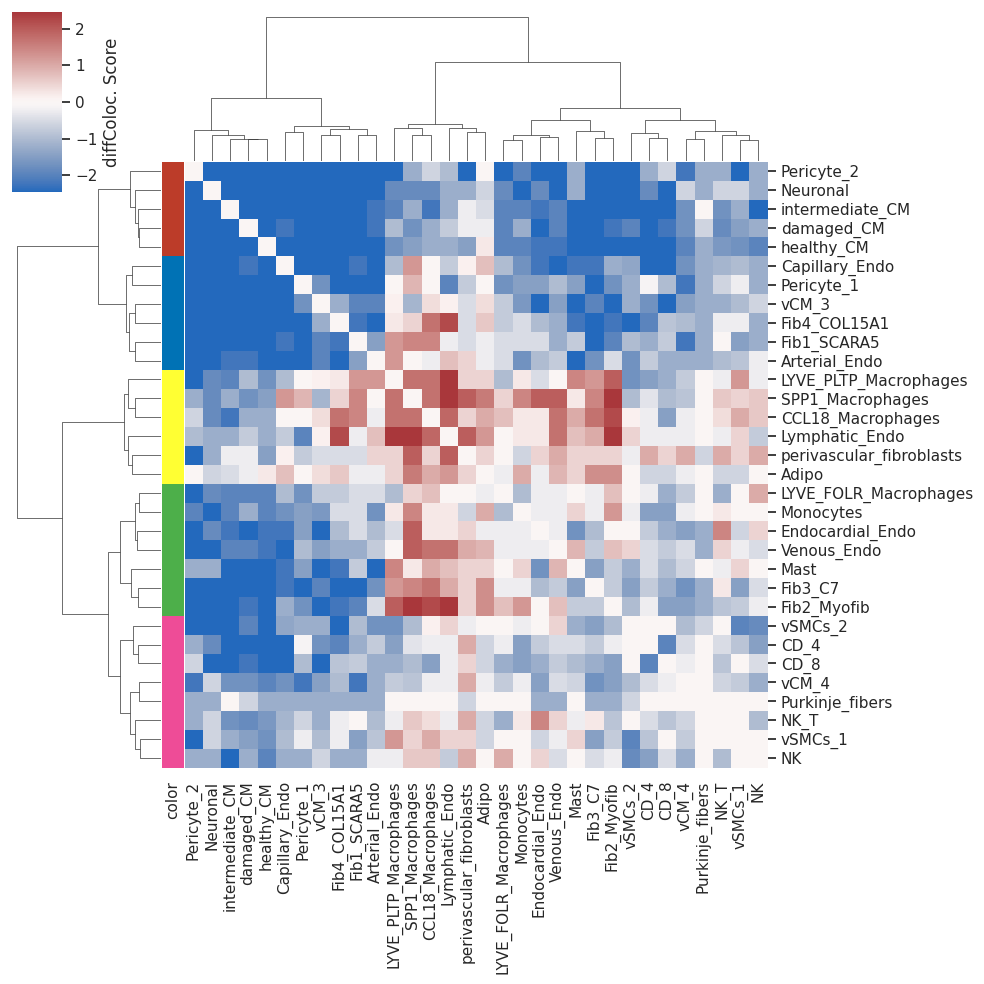

In [18]:
## Plot improved heatmap
sns.set(font_scale=1)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'}, row_colors=niches_df.color)

Now we will filter non significant co-localization differences

In [19]:
#### Filter test HM
myo_isc_HM=nichesphere.tl.pval_filtered_HMdf(testDF=myo_iscDF, oneCTinteractions=oneCTints, p=0.1, cell_types=cell_types)

In [20]:
## No prolif cells
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.columns.str.contains('prolif')==False,myo_isc_HM.index.str.contains('prolif')==False]

In [21]:
#Remove cells with no significant co-localization differences or just one enriched interaction
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.sum()!=0,myo_isc_HM.sum()!=0]
#myo_isc_HM=myo_isc_HM.loc[(myo_isc_HM!=0).sum()>1,(myo_isc_HM!=0).sum()>1]

Differential co-localization network

To build the differential co-localization network, we will get an adjacency matrix (adj) based on the cosine similarities of the distributions of significant differential co-localization scores for the different cell types

In [22]:
##Cosine similarity plus pseudocount
adj=pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(myo_isc_HM)+1)
adj.index=myo_isc_HM.index
adj.columns=myo_isc_HM.columns

In [23]:
##Cell pairs with not significant differential co-localization get 0
adj[myo_isc_HM==0]=0
adj[adj==1]=0

Then the network is built just taking into account the differentially co-localized cell type pairs. The cell groups dictionary can be used here to visualize different cell groups in different colors.

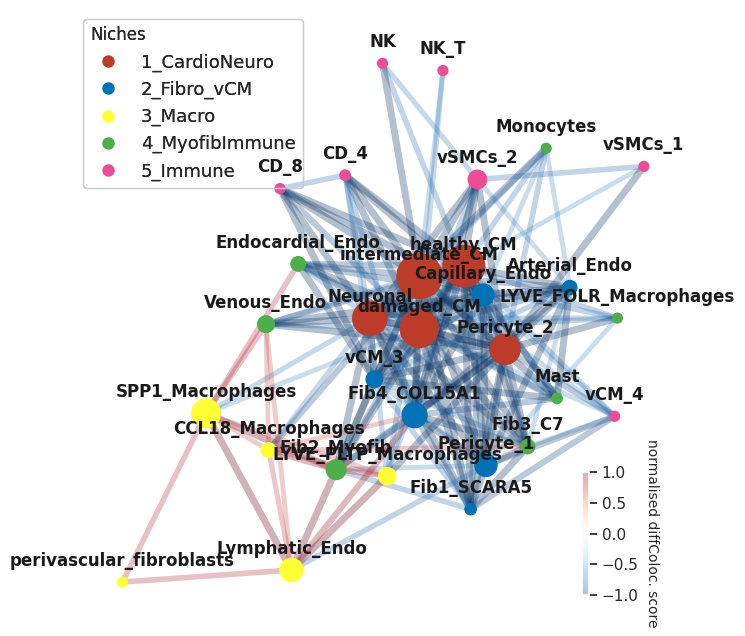

In [24]:
plt.rcParams['axes.facecolor'] = "None"

gCol=nichesphere.coloc.colocNW(x_diff=myo_isc_HM, adj=adj,cell_group=niches_dict, clist=clist, BTsizedNodes=True, layout='neato', lab_spacing=9)
nx.write_graphml_lxml(gCol, "./colocNW_MIvisium.graphml")

legend_elements1 = [plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[0], lw=4, label='1_CardioNeuro', ms=10),
                    plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[1], lw=4, label='2_Fibro_vCM', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[2], lw=4, label='3_Macro', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[3], lw=4, label='4_MyofibImmune', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[4], lw=4, label='5_Immune', ms=10),
                   ]

plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='upper left', fontsize=13, title='Niches', alignment='left'))

We can then calculate some network statistics with the networkX package [ref] functions:

In [25]:
t1=pd.DataFrame({'influencer':[nx.eigenvector_centrality(gCol)[x] for x in list(gCol.nodes)], 'betweenness':[nx.betweenness_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'degree':[nx.degree_centrality(gCol)[x] for x in list(gCol.nodes)], 'pagerank':[nx.pagerank(gCol, weight=None)[x] for x in list(gCol.nodes)]})
t1.index=list(gCol.nodes)

And visualize them

Text(0.5, 1.0, 'Betweenness')

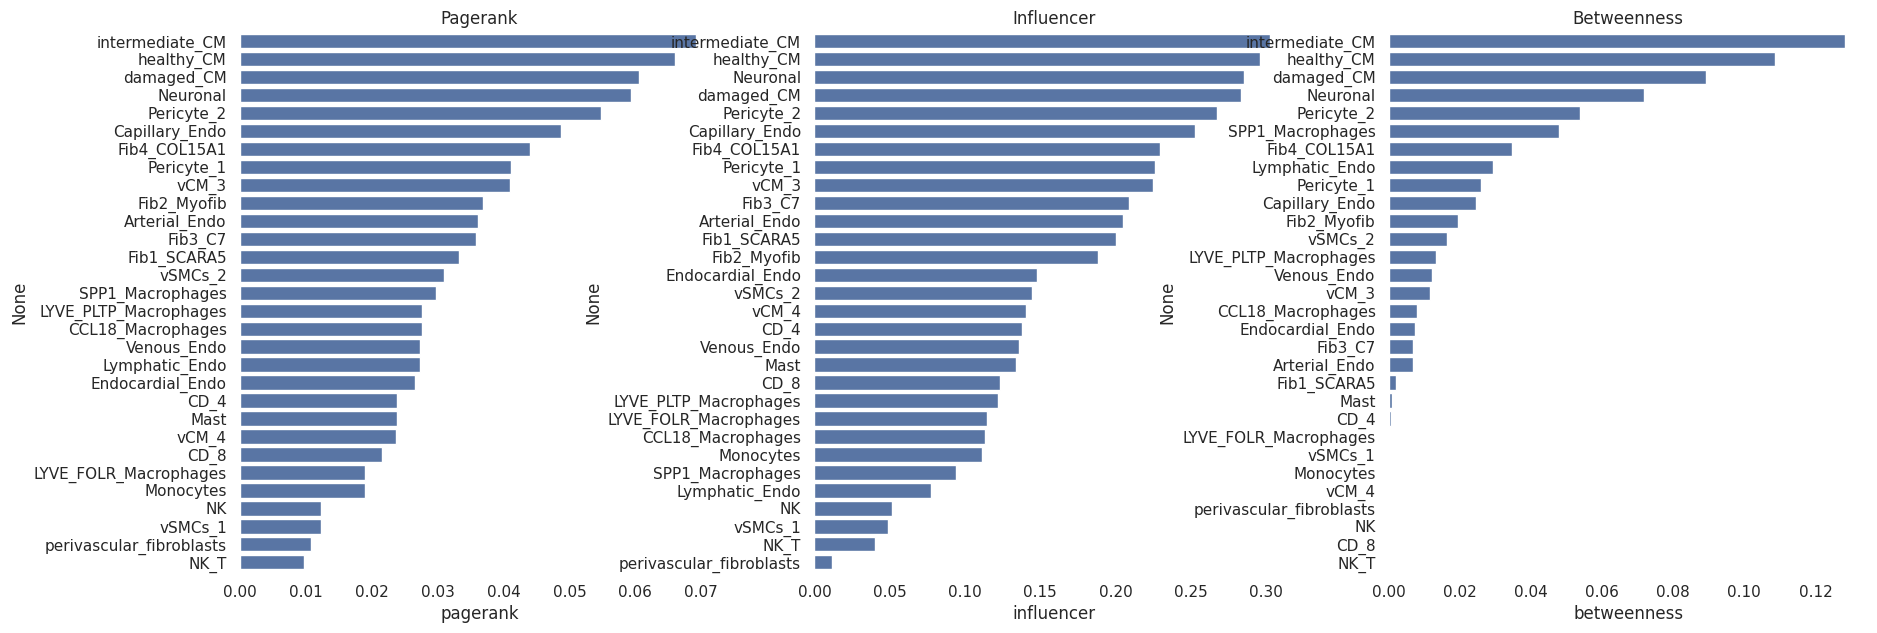

In [26]:

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
sns.barplot(ax=axes[0], y=t1.sort_values('pagerank', ascending=False).index, x='pagerank', data=t1.sort_values('pagerank', ascending=False))
axes[0].set_title('Pagerank')
sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
axes[1].set_title('Influencer')
sns.barplot(ax=axes[2], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
axes[2].set_title('Betweenness')
#plt.savefig('../../../../figures_nichesphere_tutorial/diffColocNW_stats.pdf')

And also visualize niches in slices (spots are colored by the niche to which the cell type with highest proportion belongs)

In [27]:
## Niche plots

In [28]:
## Series of sample names with spot ids as indexes 
spotSamples=mudata['visium'].obs.patient_region_id

In [29]:
## put spatial coordinates in uns.spatial
mudata['visium'].uns['spatial']=mudata['visium'].obsm['X_spatial']

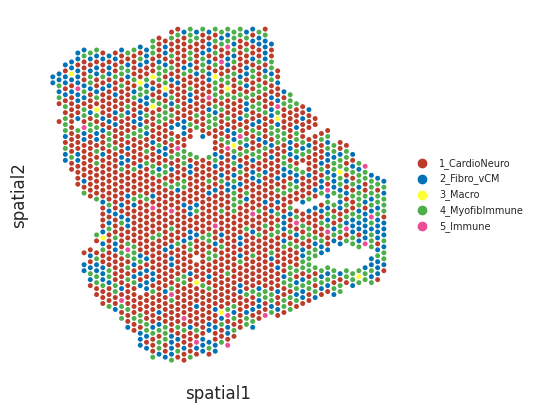

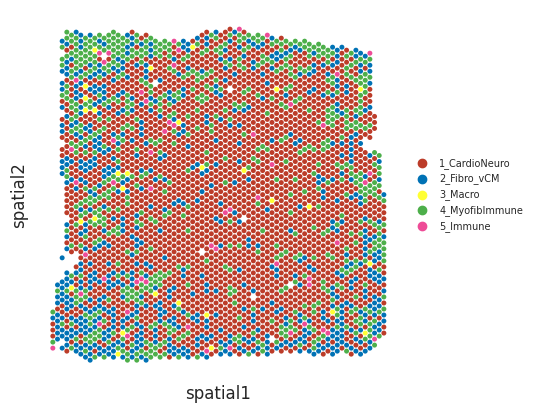

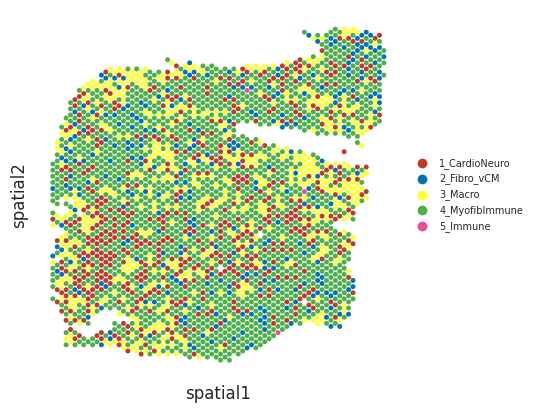

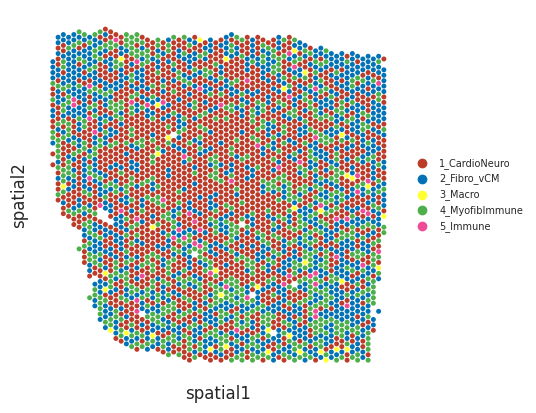

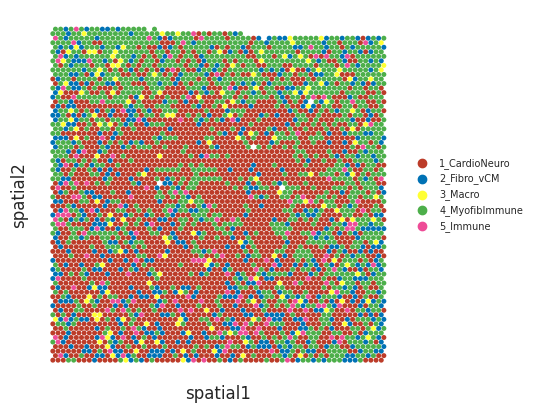

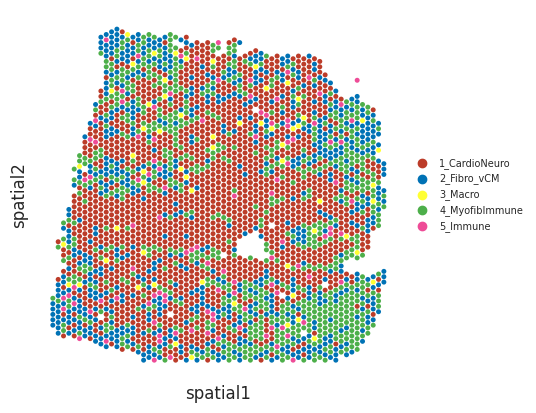

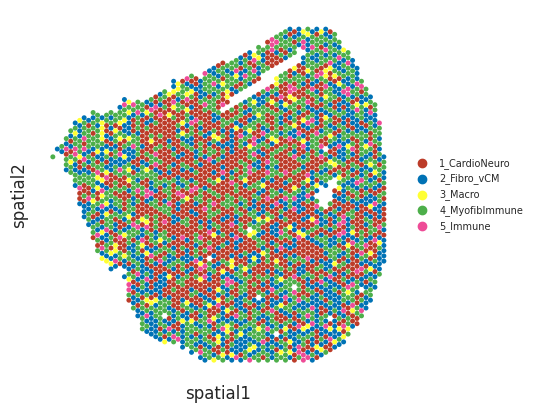

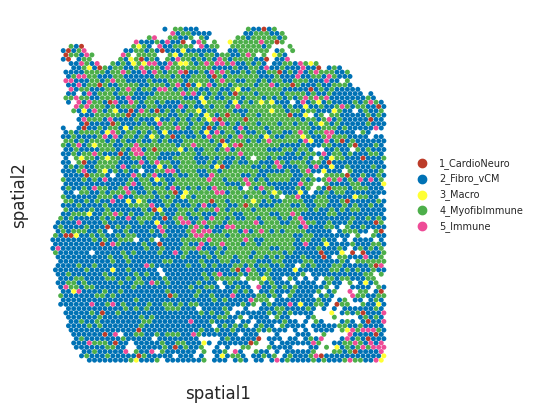

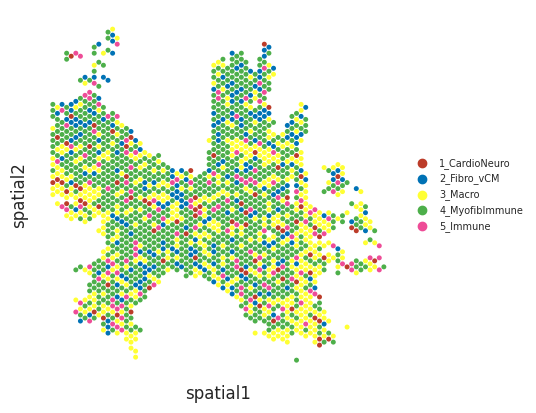

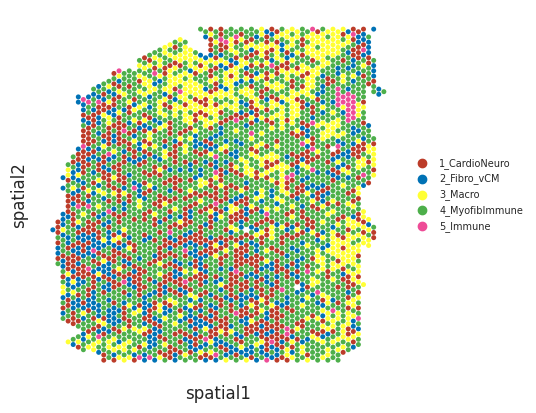

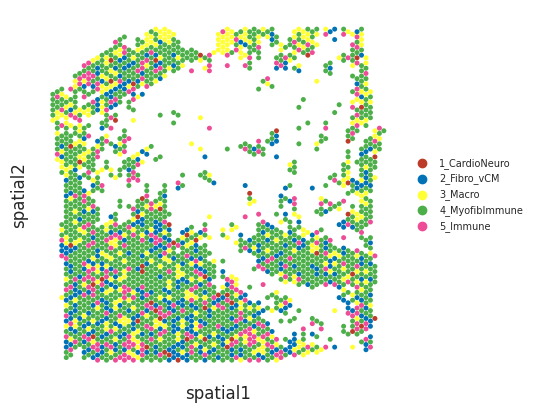

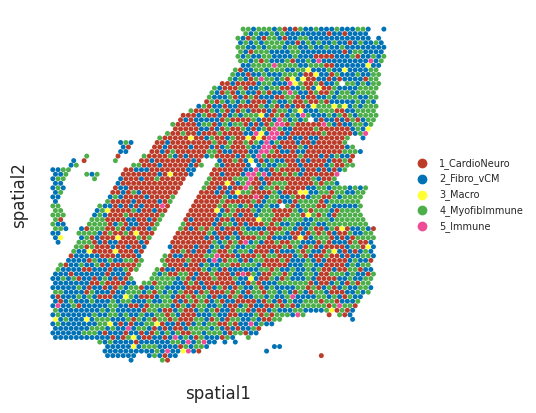

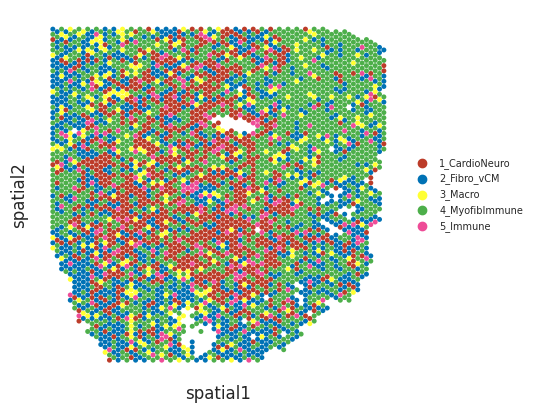

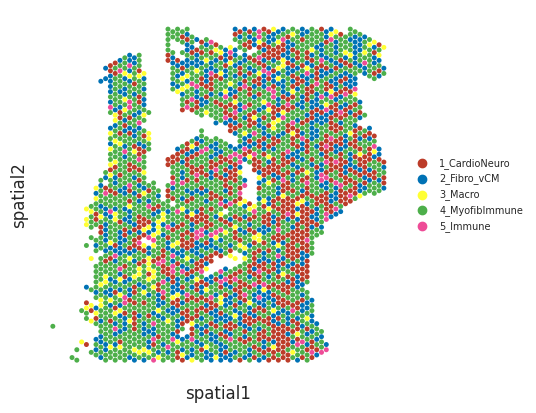

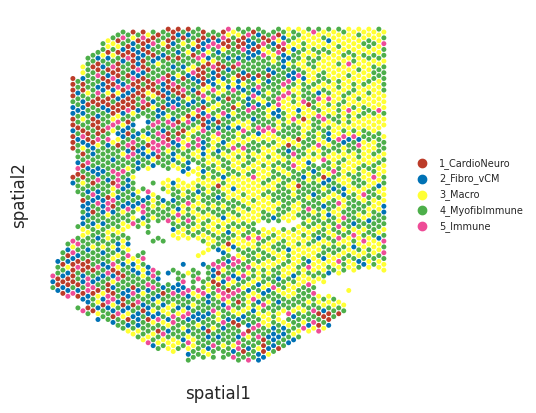

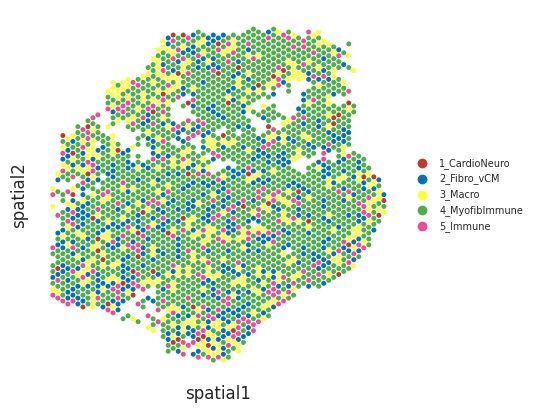

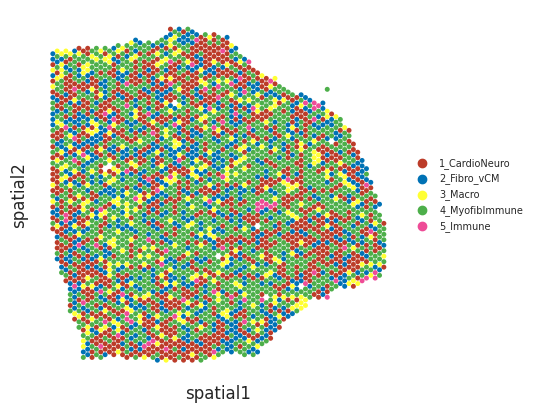

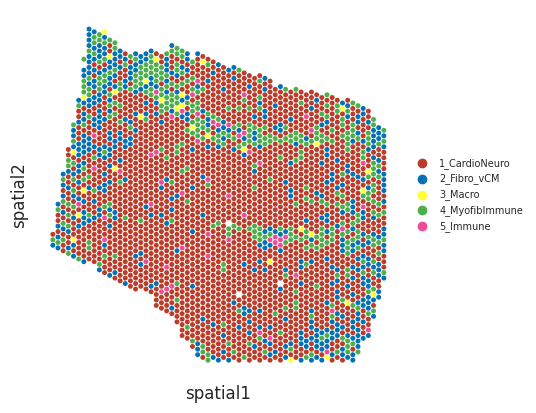

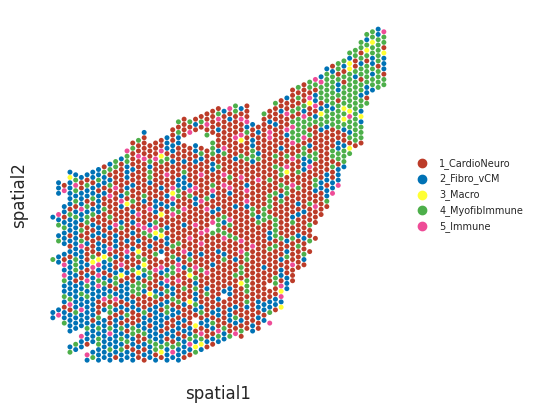

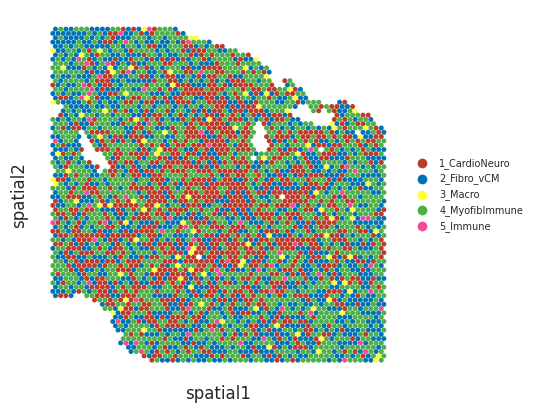

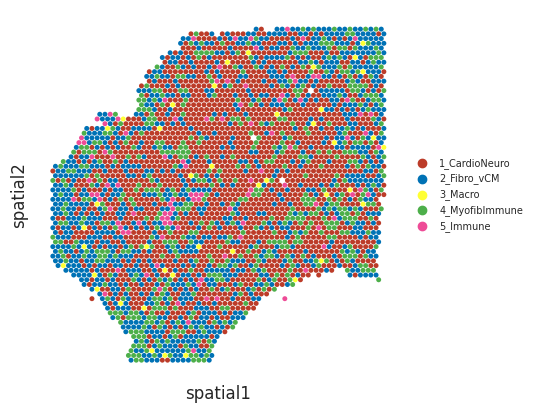

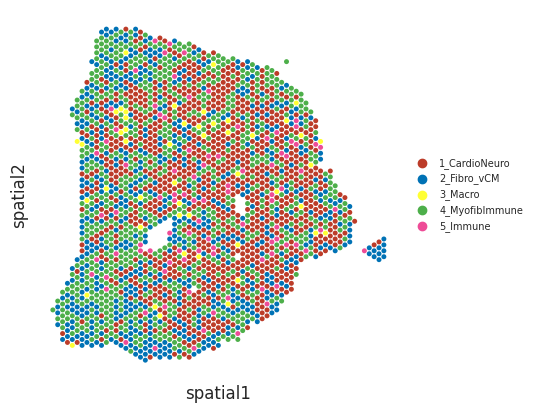

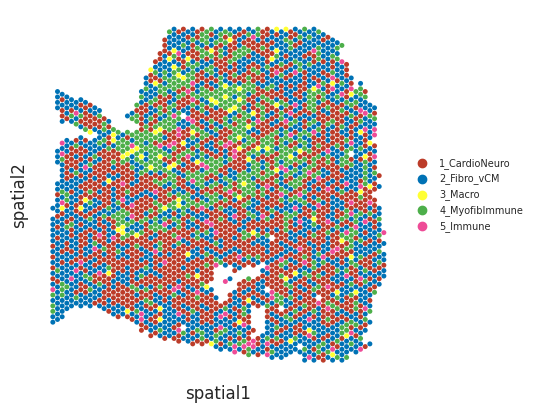

In [30]:
for smpl in  list(sampleTypesDF['sample']):  
    
    nichesphere.coloc.spatialNichePlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==smpl].copy(), CTprobs=CTprops.loc[spotSamples.index[spotSamples==smpl]], cell_types=mudata['sc'].obs.cell_subtype2, nicheDF=niches_df, spot_size=0.015, 
                     niche_colors=niche_cols, legend_fontsize=7, wspace=0.5, save_name='_'+smpl+'.pdf')


For further analysis, we will need the correspondence data between cell pairs and niche pairs

In [31]:
pairCatDFdir=nichesphere.tl.get_pairCatDFdir(niches_df)
pairCatDFdir.to_csv('./pairCatDFdir_MIvisium.csv')
pairCatDFdir

cell_pairs                  niche_pairs
0               Fib1_SCARA5->Fib1_SCARA5     2_Fibro_vCM->2_Fibro_vCM
1                Fib1_SCARA5->damaged_CM   2_Fibro_vCM->1_CardioNeuro
2            Fib1_SCARA5->Capillary_Endo     2_Fibro_vCM->2_Fibro_vCM
3     Fib1_SCARA5->LYVE_FOLR_Macrophages  2_Fibro_vCM->4_MyofibImmune
4                   Fib1_SCARA5->Fib3_C7  2_Fibro_vCM->4_MyofibImmune
...                                  ...                          ...
1084                            NK_T->NK           5_Immune->5_Immune
1085                          NK_T->CD_8           5_Immune->5_Immune
1086               NK_T->Purkinje_fibers           5_Immune->5_Immune
1087                         NK_T->Adipo            5_Immune->3_Macro
1088                          NK_T->NK_T           5_Immune->5_Immune

[1089 rows x 2 columns]

We will also need the data about which cell pairs are differentially co-localized

In [32]:
## Get data of cells present in the adjacency matrix
pairCatDF_filter=[(pairCatDFdir.cell_pairs.str.split('->')[i][0] in adj.index)&(pairCatDFdir.cell_pairs.str.split('->')[i][1] in adj.index) for i in pairCatDFdir.index]
pairCatDFdir_filt=pairCatDFdir[pairCatDF_filter]
oneCTints_filt=oneCTints[[i.split('-')[0] in adj.index for i in oneCTints]]

In [33]:
## Get data to flag differentially co-localized cell pairs in the adjacency matrix
colocFilt=nichesphere.tl.getColocFilter(pairCatDF=pairCatDFdir_filt, adj=adj, oneCTints=oneCTints_filt.str.replace('-', '->'))
colocFilt.to_csv('./colocFilt_MIvisium.csv')
colocFilt

filter
cell_pairs                                
Fib1_SCARA5->Fib1_SCARA5               1.0
Fib1_SCARA5->damaged_CM                1.0
Fib1_SCARA5->Capillary_Endo            1.0
Fib1_SCARA5->LYVE_FOLR_Macrophages     0.0
Fib1_SCARA5->Fib3_C7                   1.0
...                                    ...
NK_T->vSMCs_2                          0.0
NK_T->Lymphatic_Endo                   0.0
NK_T->NK                               0.0
NK_T->CD_8                             0.0
NK_T->NK_T                             1.0

[900 rows x 1 columns]